In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
            candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
            candidates.append(candidate)
    
    '''f_E = []
    for e in energies:
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [2]:
import kwant
import tinyarray
import numpy as np
import scipy as spi

import matplotlib.pyplot as plt 
import matplotlib.colors as colors

In [27]:
print(kwant.digest.gauss('3', '12ibajd'))

-0.35289335662450766


In [81]:
## function for phase-on-delta implementation

#infinite implementation (transparency changed to mismatched chemical potential)

def make_system_disorder(W=10, t=1.5, nu=2., mu=0., U_0=1., delta=1., B=2., phi=0, salt='chizhang'):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #### Define onsite and hopping ####
    def onsite(site):
        return (2.*t-mu-U_0*kwant.digest.gauss(repr(site), repr(salt)))*tau_z + B*tau_z@sigma_x
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = onsite
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    #### Define callable methods ####
    def plot_mu():
        site_array = np.arange(0, W+2)
        mu_array.append(mu)
        plt.plot(site_array, mu_array)
        plt.xlabel('sites')
        plt.ylabel(r'$\mu$')
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [227]:
## function for phase-on-delta implementation

#infinite implementation (transparency changed to mismatched chemical potential)

def make_system_uni_disorder(W=10, t=1.5, nu=2., mu=0., U_0=1., delta=1., B=2., phi=0, salt='chizhang'):
    a = 1
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
    tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
    tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
    sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
    sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
    sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
    
    
    #### Define onsite and hopping ####
    def onsite(site):
        return (2.*t-mu-2.*U_0*(kwant.digest.uniform(repr(site), repr(salt))-0.5))*tau_z + B*tau_z@sigma_x
    
    #### Define the scattering region. ####
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    syst[(lat(W+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    
    syst[(lat(x) for x in range(1, W+1))] = onsite
    
    syst[(lat(0), lat(1))] = -spi.linalg.expm(1j*phi*tau_z/2.)@(t*tau_z + 1j*nu*tau_z@sigma_y)
    if W>0:
        syst[((lat(x), lat(x+1)) for x in range(1, W+1))] = -t*tau_z - 1j*nu*tau_z@sigma_y
    
    '''syst[(lat(x) for x in range(1, L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x
    syst[(lat(0))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(-L_s, 1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(phi*1j*tau_z/2.)@tau_y@sigma_y
    syst[(lat(L+1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    #syst[(lat(x) for x in range(L+1, L+2+L_s))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*spi.linalg.expm(-phi*1j*tau_z/2.)@tau_y@sigma_y
    
    syst[((lat(x), lat(x+1)) for x in range(1, L))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(0), lat(1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    syst[(lat(L), lat(L+1))] = -tau*t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    
    #syst[((lat(x), lat(x+1)) for x in range(-L_s, 0))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y
    #syst[((lat(x), lat(x+1)) for x in range(L+1, L+1+L_s))] = -t*tau_z - 1j*(alpha_so/(2.*a))*tau_z@sigma_y'''
    
    #### Define callable methods ####
    def plot_mu():
        site_array = np.arange(0, W+2)
        mu_array.append(mu)
        plt.plot(site_array, mu_array)
        plt.xlabel('sites')
        plt.ylabel(r'$\mu$')
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead0[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(W+2))] =  (2.*t-mu)*tau_z + B*tau_z@sigma_x + delta*tau_y@sigma_y
    lead1[lat.neighbors()] = -t*tau_z - 1j*nu*tau_z@sigma_y

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [237]:
syst = make_system_disorder(W=10, salt='chizhang', U_0=100., phi=np.pi)
e, psi = find_boundstates(syst, -1.1, 1.1, rtol=1e-2)
print('e')
print(e)
print('psi')
print(psi)

e
[2.2937878e-09 2.2937878e-09]
psi
[[ 1.65325972e-01-1.89840870e-01j  2.70071614e-05-3.11433273e-05j]
 [-8.05865394e-02+9.25360883e-02j -1.31643785e-05+1.51805124e-05j]
 [-1.65325972e-01+1.89840870e-01j -2.70071614e-05+3.11433273e-05j]
 [ 8.05865394e-02-9.25360884e-02j  1.31643785e-05-1.51805124e-05j]
 [-5.81086392e-03-5.06048421e-03j -9.53270162e-07-8.26665714e-07j]
 [-2.87524666e-03-2.50395475e-03j -4.71683192e-07-4.09038648e-07j]
 [-5.81086392e-03-5.06048421e-03j -9.53270163e-07-8.26665715e-07j]
 [-2.87524666e-03-2.50395475e-03j -4.71683192e-07-4.09038648e-07j]
 [-5.78650617e-05-5.03927187e-05j -9.49277258e-09-8.23159405e-09j]
 [-1.04538232e-03-9.10387992e-04j -1.71494595e-07-1.48718341e-07j]
 [-5.78650620e-05-5.03927190e-05j -9.49277263e-09-8.23159409e-09j]
 [-1.04538232e-03-9.10387992e-04j -1.71494595e-07-1.48718341e-07j]
 [ 3.30712480e-05+2.88006277e-05j  5.42522041e-09+4.70625095e-09j]
 [-2.80923139e-05-2.44646430e-05j -4.60867629e-09-3.99450740e-09j]
 [ 3.30712480e-05+2.880062

[Text(0.5, 0, 'Site indices'), Text(0, 0.5, '$\\mu$')]

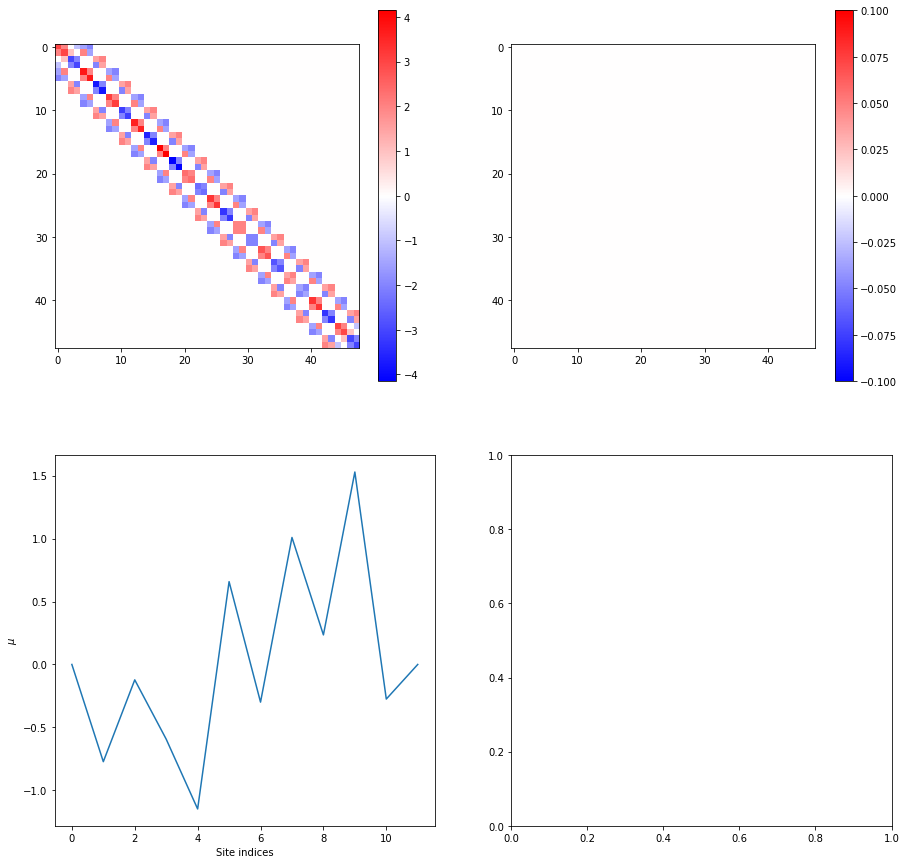

In [236]:
syst = make_system_disorder(W=10, salt='chizhang', U_0=1.)
ham_bdg = syst.hamiltonian_submatrix()

norm1 = colors.TwoSlopeNorm(vcenter=0)
norm2 = colors.TwoSlopeNorm(vcenter=0)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
im1 = ax1.imshow(np.real(ham_bdg), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(ham_bdg), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)
im3 = ax3.plot(np.arange(0, 12), mu_profile(syst))
ax3.set(xlabel='Site indices', ylabel=r'$\mu$')

In [83]:
def mu_profile(syst, t=1.5):
    ham = syst.hamiltonian_submatrix()
    mu_array = []
    for i in range(0, ham.shape[0], 4):
        mu_array.append(np.real(2.*t-ham[i][i]))
    return np.array(mu_array)

In [232]:
def phi_scan(W=10, B=2., t=1.5, nu=2., mu=0., delta=1., U_0=1., phi_array=[0., 4*np.pi], salt='chizhang', mode='gauss'):
    energy_arrays=[]
    wavefunc_arrays=[]
    if mode=='gauss':
        for i in np.linspace(phi_array[0], phi_array[1], 41):
            print(i)
            syst = make_system_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=i, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    elif mode=='uniform':
        for i in np.linspace(phi_array[0], phi_array[1], 41):
            print(i)
            syst = make_system_uni_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=U_0, delta=delta, phi=i, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    else:
        print('mode must be either "uniform" or "gauss"!')
    return energy_arrays, wavefunc_arrays

In [231]:
def U0_gap_scan(W=10, B=2., t=1.5, nu=2., mu=0., delta=1., U0_array=[0, 5], phi=np.pi, salt='chizhang', mode='gauss'):
    energy_arrays=[]
    wavefunc_arrays=[]
    if mode=='gauss':
        for i in np.linspace(U0_array[0], U0_array[1], 51):
            print(i)
            syst = make_system_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=i, delta=delta, phi=phi, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    elif mode=='uniform':
        for i in np.linspace(U0_array[0], U0_array[1], 51):
            print(i)
            syst = make_system_uni_disorder(W=W, B=B, t=t, nu=nu, mu=mu, U_0=i, delta=delta, phi=phi, salt=salt)
            energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
            energy_arrays.append(energies)
            wavefunc_arrays.append(wavefunctions)
            print(energies)
    else:
        print('mode must be either "uniform" or "gauss"!')
    return energy_arrays, wavefunc_arrays

In [185]:
def phi_plot(energy_array, figure_title, phi_range=[0, 4*np.pi], delta=1., title=r'$W=10, B=2, t=1.5, \nu=2, \mu=0, U_0=1, \Delta=1, salt=chizhang$'):
    ex=[]
    ey=[]
    phi_array=np.linspace(phi_range[0], phi_range[1], 41)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(phi_array[i])
            ey.append(energy_array[i][j])
            
    ey = np.array(ey)/delta
    plt.scatter(ex, ey)
    plt.xlim(0, 4*np.pi)
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman4/'+figure_title, dpi=300)

In [217]:
def U0_plot(energy_array, figure_title, U0_range=[0, 5], delta=1., title=r'$W=10, B=2, t=1.5, \nu=2, \mu=0, U_0=1, \Delta=1, salt=chizhang$'):
    ex=[]
    ey=[]
    U0_array=np.linspace(U0_range[0], U0_range[1], 51)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(U0_array[i])
            ey.append(energy_array[i][j])
            
    ey = np.array(ey)/delta
    plt.scatter(ex, ey)
    plt.xlim(0, 5)
    plt.xlabel(r'$U_0$')
    plt.ylabel(r'$E/\Delta$')
    plt.title(title)
    plt.savefig('./Keselman4/'+figure_title, dpi=300)

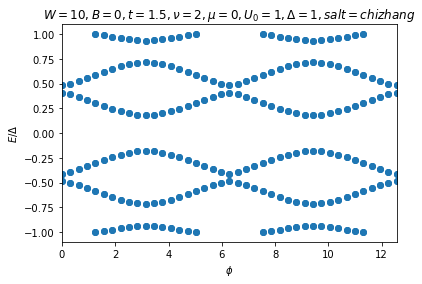

In [194]:
phi_plot(e_array3, 'phi_scan with disorder~1 (trivial case)', title=r'$W=10, B=0, t=1.5, \nu=2, \mu=0, U_0=1, \Delta=1, salt=chizhang$')

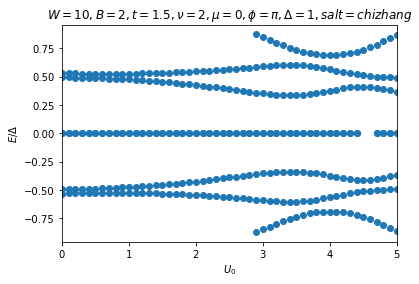

In [234]:
U0_plot(e_array7, 'U0_gap_scan (topological phase) (uniform disorder)', title=r'$W=10, B=2, t=1.5, \nu=2, \mu=0, \phi=\pi, \Delta=1, salt=chizhang$')

In [247]:
import pickle
pickle.dump(e_array7, open('./Keselman4/data/U0_gap_scan(mode=uniform)', 'wb'))

In [176]:
np.arange(0, 4*np.pi+np.pi/10., np.pi/10.)

array([ 0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,
        1.57079633,  1.88495559,  2.19911486,  2.51327412,  2.82743339,
        3.14159265,  3.45575192,  3.76991118,  4.08407045,  4.39822972,
        4.71238898,  5.02654825,  5.34070751,  5.65486678,  5.96902604,
        6.28318531,  6.59734457,  6.91150384,  7.2256631 ,  7.53982237,
        7.85398163,  8.1681409 ,  8.48230016,  8.79645943,  9.1106187 ,
        9.42477796,  9.73893723, 10.05309649, 10.36725576, 10.68141502,
       10.99557429, 11.30973355, 11.62389282, 11.93805208, 12.25221135,
       12.56637061])

In [181]:
np.linspace(0, 4.*np.pi, 41)

array([ 0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,
        1.57079633,  1.88495559,  2.19911486,  2.51327412,  2.82743339,
        3.14159265,  3.45575192,  3.76991118,  4.08407045,  4.39822972,
        4.71238898,  5.02654825,  5.34070751,  5.65486678,  5.96902604,
        6.28318531,  6.59734457,  6.91150384,  7.2256631 ,  7.53982237,
        7.85398163,  8.1681409 ,  8.48230016,  8.79645943,  9.1106187 ,
        9.42477796,  9.73893723, 10.05309649, 10.36725576, 10.68141502,
       10.99557429, 11.30973355, 11.62389282, 11.93805208, 12.25221135,
       12.56637061])

In [ ]:
e_array0, psi_array0 = phi_scan(U_0=0.)
print(e_array0)

In [ ]:
e_array1, psi_array1 = phi_scan(U_0=1.)

In [ ]:
e_array2, psi_array2 = phi_scan(U_0=0., B=0.)

In [ ]:
e_array3, psi_array3 = phi_scan(U_0=1., B=0.)

In [ ]:
e_array4, psi_array4 = U0_gap_scan()

In [ ]:
e_array5, psi_array5 = U0_gap_scan(B=0.)

In [ ]:
e_array6, psi_array6 = U0_gap_scan(salt='13')

In [ ]:
e_array7, psi_array7 = U0_gap_scan(mode='uniform')

In [159]:
e, psi = find_boundstates(syst, -1.1, 1.1, rtol=1e-2)
print('e')
print(e)
print('psi')
print(psi)

e
[-0.46634102 -0.46634102 -0.40905623 -0.40905623  0.40905623  0.40905623
  0.46634102  0.46634102]
psi
[[ 1.46755705e-01-3.66027100e-02j -6.79554466e-03-6.25164542e-02j
   1.84409817e-02+3.14121801e-02j  2.37129197e-02+3.09737991e-02j
  -5.97863364e-03+1.52435651e-01j  1.92331415e-02-4.14395406e-03j
  -6.99027823e-02+7.59723973e-03j -7.03143149e-02-1.18937875e-04j]
 [ 8.74643816e-02-2.18147117e-02j  1.77725638e-02+1.63500901e-01j
   2.06294079e-02+3.51399230e-02j -2.32710968e-02-3.03966904e-02j
   6.27690692e-04-1.60040642e-02j -1.48711689e-01+3.20412767e-02j
  -1.19420054e-02+9.68850937e-02j -2.21794357e-02-9.50652697e-02j]
 [-5.97607633e-02+1.49050825e-02j -1.21432515e-02-1.11713345e-01j
   5.78970891e-02+9.86213112e-02j -6.53110730e-02-8.53092780e-02j
  -2.23653512e-04+5.70243467e-03j  5.29877085e-02-1.14166804e-02j
  -1.74780250e-02+1.41798638e-01j -3.24612759e-02-1.39135188e-01j]
 [ 1.00272051e-01-2.50091048e-02j -4.64311218e-03-4.27148852e-02j
  -5.17552014e-02-8.81592823e-02j 

In [154]:
def wavefunc_visualiser(syst, psi, index):
    wavefunc = psi[:, index]
    orbitals = []
    for i in range(4):
        orbitals.append(wavefunc[i::4])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
    ax1.plot(np.arange(0, 12), np.abs(orbitals[0])**2.)
    ax1.set(xlabel='Site indices', ylabel='Probability density')
    ax2.plot(np.arange(0, 12), np.abs(orbitals[1])**2.)
    ax2.set(xlabel='Site indices', ylabel='Probability density')
    ax3.plot(np.arange(0, 12), np.abs(orbitals[2])**2.)
    ax3.set(xlabel='Site indices', ylabel='Probability density')
    ax4.plot(np.arange(0, 12), np.abs(orbitals[3])**2.)
    ax4.set(xlabel='Site indices', ylabel='Probability density')
    
    for i in range(4):
        print(np.sum(np.abs(orbitals[i])**2.))
    
        

0.06343161589410845
0.01507357967524517
0.06343161589795475
0.015073579694638585


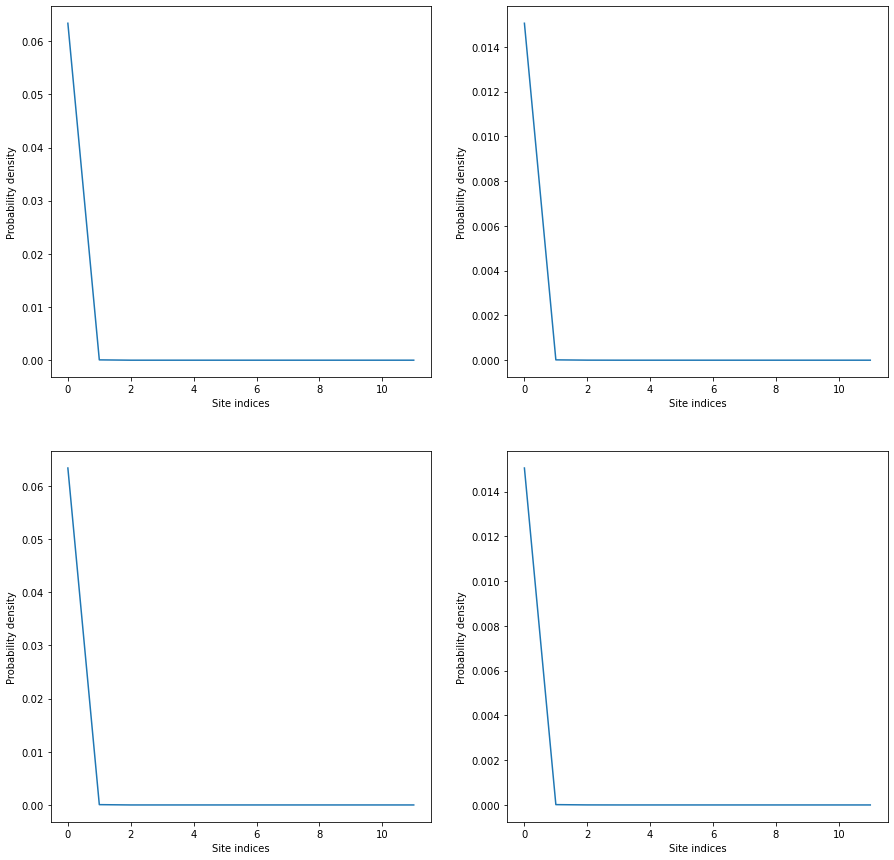

In [238]:
wavefunc_visualiser(syst, psi, 0)

0.014034739534547773
0.06517099066228747
0.014034739547173538
0.06517099065091753


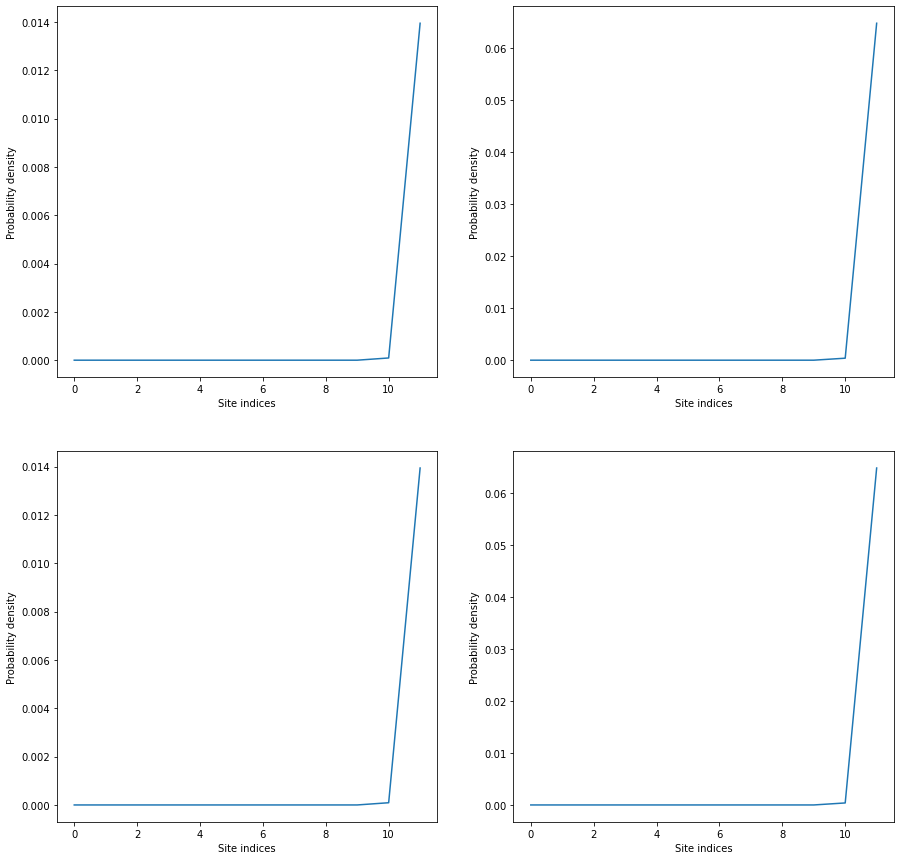

In [239]:
wavefunc_visualiser(syst, psi, 1)

1.4142135623730951